In [7]:
import numpy as np
import pandas as pd
import scipy as scp

## data import

In [23]:
from astroquery.vizier import Vizier


VizOC = Vizier(catalog="J/A+A/659/A59/table2")
VizOC.ROW_LIMIT = -1

cluster = "Blanco_1"
OC_df = VizOC.query_constraints(Cluster=cluster).values()[0].to_pandas()

#Pulling mean cluster parameters from table 1.
VizOC_t1 = Vizier(catalog="J/A+A/659/A59/table1")
OC_df_t1 = VizOC_t1.query_constraints(Cluster=cluster).values()[0].to_pandas()

#Check table 1..
print(OC_df_t1['RA_ICRS'], OC_df_t1['DE_ICRS'])

#function to convert ICRS ra, dec, distance to heliocentric cartesian coordinates (x,y,z)

def radec_to_helio(ra,dec,dist):
    
    """
    The cartesian positional coordinates in the ICRS reference frame
    caluclated from the galacitc coordinates l,b and distance.kinematics_mock_2
    """

    c = np.cos
    s = np.sin
    A = np.array([c(dec)*c(ra), c(dec)*s(ra),s(dec)]).T

    r = A*dist
    print(r.shape)
    return r[:,0], r[:,1], r[:,2]

x,y,z = radec_to_helio(OC_df['RA_ICRS'], OC_df['DE_ICRS'], OC_df_t1['Dist'][0])
x


0    0.719918
Name: RA_ICRS, dtype: float64 0   -30.115541
Name: DE_ICRS, dtype: float64
(529, 3)


array([ 8.14113140e+00,  2.29321029e+00,  5.10084919e+01,  3.51384890e+01,
       -1.05750638e+00,  2.27864648e+01,  3.21045880e+01,  3.18827435e+01,
        3.26412806e+01,  3.36318654e+01,  2.79234382e+01,  1.86718227e+01,
        2.79862419e+01,  8.01336140e+00,  6.25903432e+00,  5.72915585e+00,
        2.37841742e+01,  1.21892969e+01,  1.04464780e+01, -5.41216714e+01,
        6.37516571e+01,  5.03074100e+01,  5.43803096e+01,  4.76289552e+01,
        4.44474488e+01,  2.98403082e+01,  4.08522686e+01,  2.46982420e+01,
        1.34950798e+01,  6.48718254e+01,  9.27941516e+00,  6.75102223e+01,
        2.50825761e+01,  1.18258433e+02,  1.18274037e+02,  1.21333601e+02,
        6.80807533e+01,  6.56985393e+01,  6.74753345e+01,  5.62836495e+01,
        1.61587228e+01,  1.94403301e+01,  2.07002678e+01,  1.28360789e+01,
        1.94124733e+01,  6.92319405e+01,  1.03946661e+01,  1.18768514e+01,
        3.10777900e+00,  1.43446668e+01,  2.21125119e+00, -9.35560795e+00,
       -9.57012742e+00,  

## building density profile

In [21]:
OC_df_t1

,Cluster,logAgeNN,Dist,Nstars,RA_ICRS,DE_ICRS,pmRA,s_pmRA,pmDE,s_pmDE,...,aHalo,e_aHalo,bHalo,e_bHalo,NstarsSeg,lambda10,e_lambda10,SimbadName,_RA.icrs,_DE.icrs
0,Blanco_1,8.03,239.0,512,0.719918,-30.115541,18.722497,0.30251,2.567345,0.265266,...,24.157332,0.000005,20.84285,0.000203,2,1.552835,0.536714,Cl Blanco 1,0.719822,-30.115552


## fit different functions

48.70591467683875


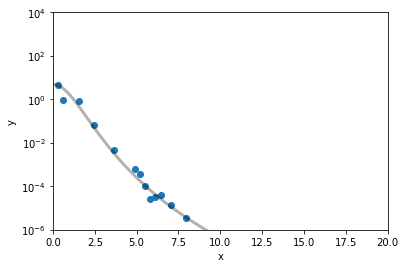

In [84]:
import matplotlib.pyplot as plt

np.random.seed(123)

def radial_profile(r, rho_0=1., a=2):
    plummer = rho_0*(1 + r**2/a**2)**-5/2
    
    return plummer

# Choose the "true" parameters.
rho0_true = 10.0
a_true = 2.

# Generate some synthetic data from the model.
N = 50
r = np.linspace(0,15,N)
y = radial_profile(r, rho0_true, a_true)

#Add gaussian errors to data
yerr = y*np.random.normal(size=N)
y = y + yerr

plt.scatter(r, yerr)
x0 = np.linspace(0, 10, 30)
plt.plot(r, radial_profile(r, rho0_true, a_true), "k", alpha=0.3, lw=3)
plt.yscale("log")
plt.ylim(1e-6,1e4)
plt.xlim(0, 20)
plt.xlabel("x")
plt.ylabel("y")

print(np.random.normal(N))

## compare models

In [86]:
from scipy.optimize import least_squares

def radial_for_fitting(theta,r):
    plummer = theta[0]*(1 + r**2/theta[1]**2)**-5/2
    return plummer


def fun(theta):
    return radial_for_fitting(theta, r) - y

theta0=[50.,1.5]
res = least_squares(fun, theta0)

print(res.x, cov)

[8.20775809 2.04315957] [[ 1.37947009e-29 -6.55469144e-28]
 [-6.55469144e-28  3.12345575e-26]]


In [ ]:
def y(theta, t):
    return theta[0] / (1 + np.exp(- theta[1] * (t - theta[2])))

ts = np.linspace(0, 1)
K = 1; r = 10; t0 = 0.5; noise = 0.1
ys = y([K, r, t0], ts) + noise * np.random.rand(ts.shape[0])

def fun(theta):
    return y(theta, ts) - ys

theta0 = [1,2,3]
res1 = least_squares(fun, theta0)

## HOORAY!!!